# Daniel Lupercio HW2

## 13. This question should be answered using the $Weekly$ data set, which is part of the ISLR2 package. This data is similar in nature to the $Smarket$ data from this chapter’s lab, except that it contains 1, 089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

In [86]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #problem will be solved with scikit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import preprocessing
from sklearn import neighbors
from patsy import dmatrices

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [87]:
# ROC
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'violet', 'orange', 'purple']
    
def plot_roc(name, labels, predictions, **kwargs):
    
    #plt.figure(figsize = (6, 6))
    plt.style.use('ggplot')
    
    fp, tp, _ = roc_curve(labels, predictions)

    lbl = name + " AUC: "+str(round(roc_auc_score(1-labels, 1-predictions.ravel()),3))
    plt.plot(100*fp, 100*tp, label=lbl, linewidth=2, **kwargs)
    plt.plot(100*fp, 100*fp,'r--');
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    #plt.grid(True)
    
    #plt.plot(fpr, tpr, label = "ROC score: "+str(round(roc_auc_score(1-y_test, 1-pred_vals[:,1]),3)), color = "violet", lw = 3);

    ax = plt.gca()
    ax.set_aspect('equal')

In [88]:
import os
UP_DIR = '/Users/daniel421/Desktop/STAT_724/ISLR_data'
csv_file = os.path.join(UP_DIR,'Weekly.csv')
weekly = pd.read_csv(csv_file, index_col = 0)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [89]:
#weekly['Week'] = weekly[1:weekly.count]
weekly.count()

Year         1089
Lag1         1089
Lag2         1089
Lag3         1089
Lag4         1089
Lag5         1089
Volume       1089
Today        1089
Direction    1089
dtype: int64

In [90]:
weekly['Direction2'] = weekly.Direction.map({'Up':1,'Down':0})

### (a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [91]:
weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction2
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899,0.555556
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927,0.497132
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000,0.000000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000,0.000000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000,1.000000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000,1.000000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000,1.000000


In [92]:
weekly.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction2
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460,-0.022200
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032,-0.050004
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167,0.072696
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244,-0.022913
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826,-0.020549
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013,-0.018168
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078,-0.017995
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000,0.720025
Direction2,-0.022200,-0.050004,0.072696,-0.022913,-0.020549,-0.018168,-0.017995,0.720025,1.000000


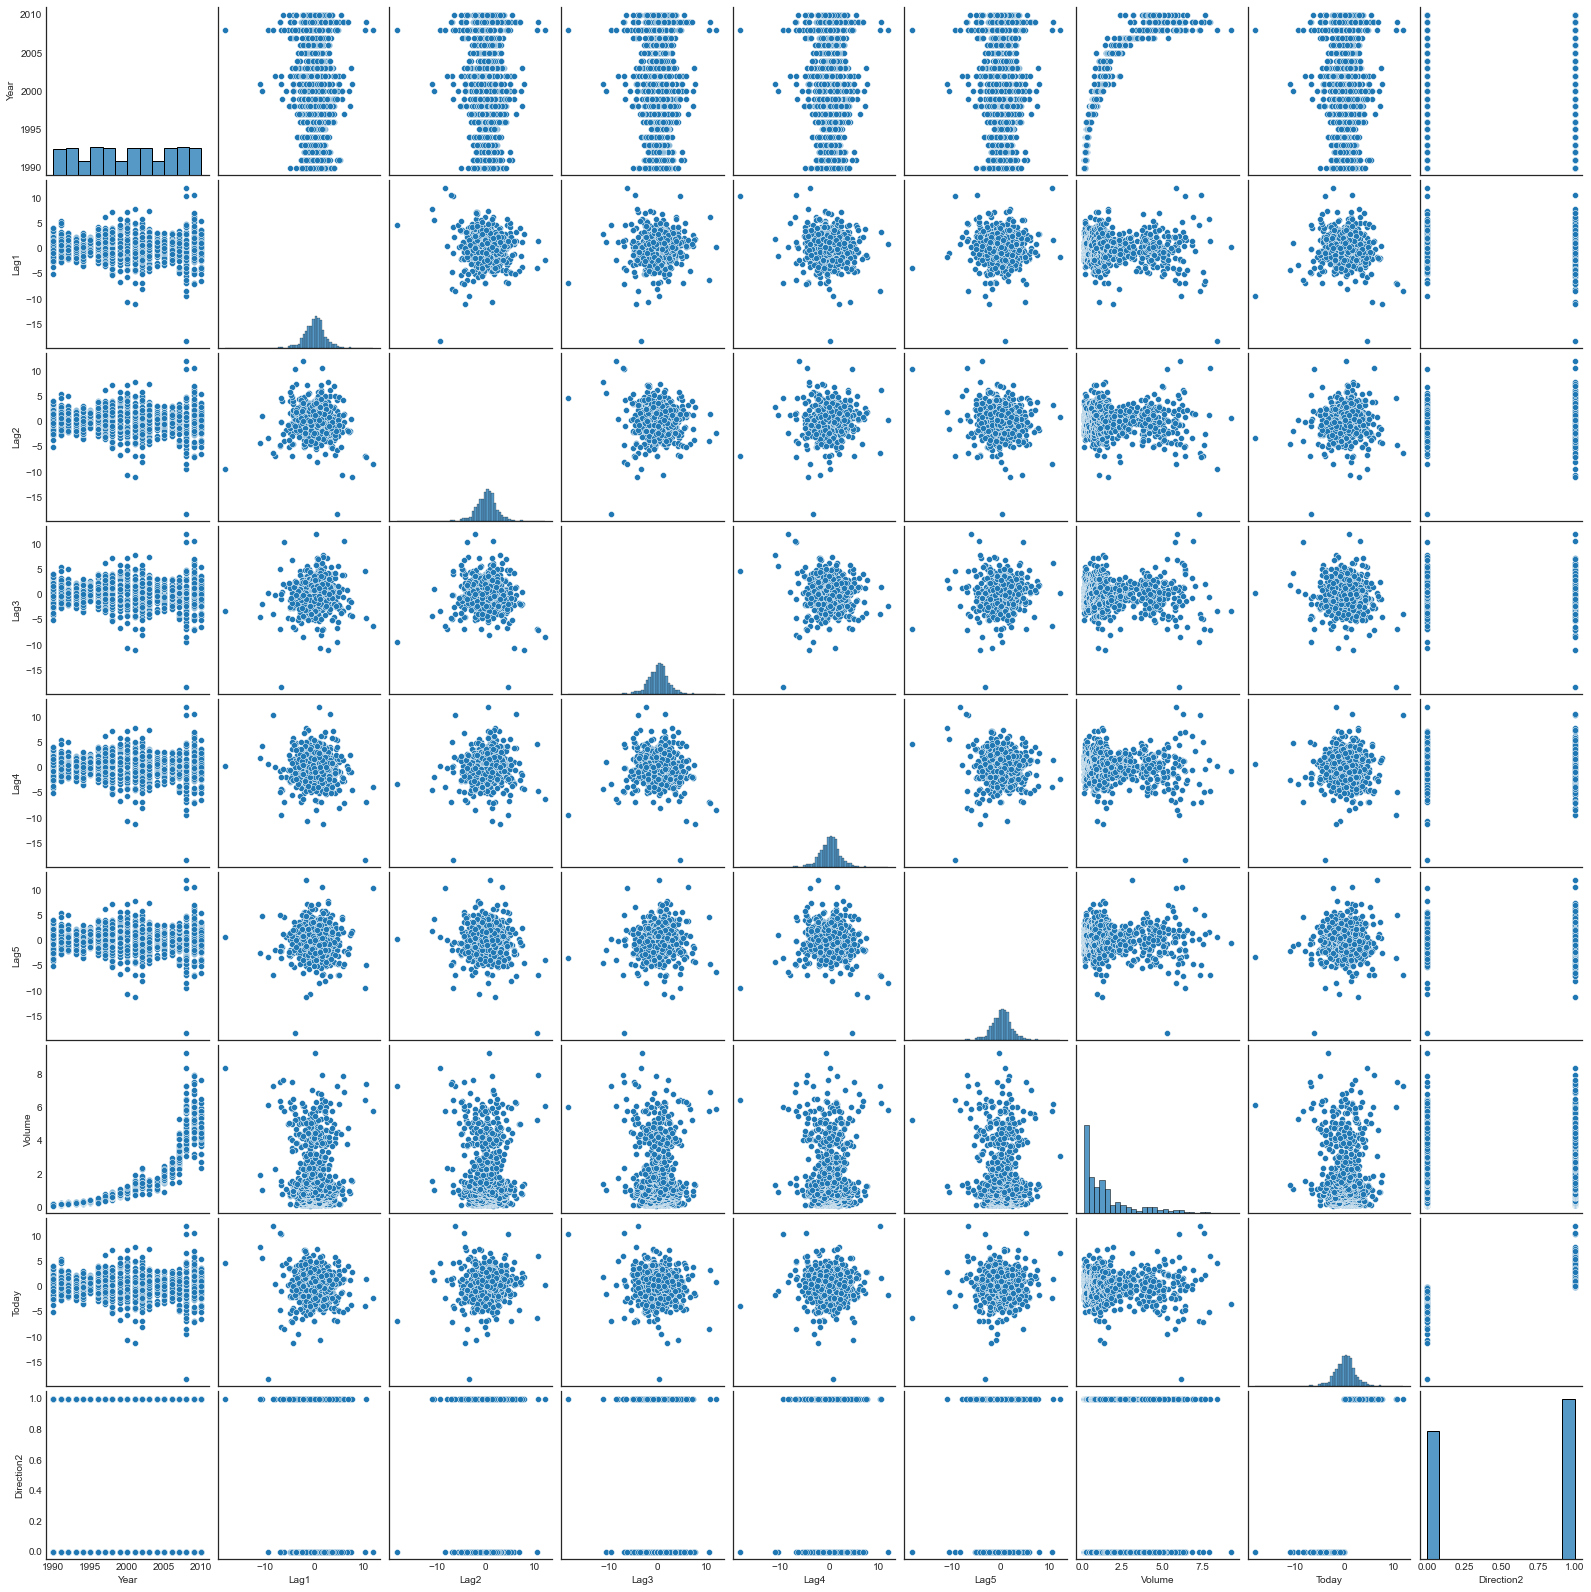

In [93]:
sns.pairplot(weekly)

The distribution of the Lags appear to be normally distributed. The distribution of $Volume$ is skewed to the right. We are seeing little to no correlation between the $Year$ and $Lags$

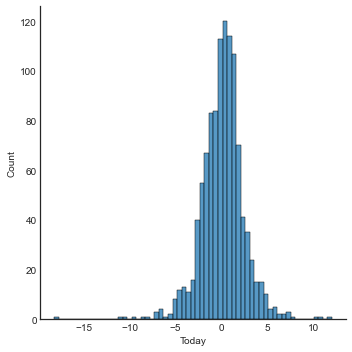

In [94]:
sns.displot(weekly['Today']);

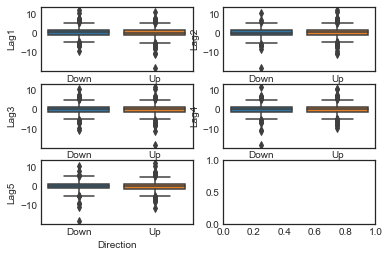

In [95]:
ig, axes = plt.subplots(nrows=3, ncols=2) # create 2x2 array of subplots
sns.boxplot(x = "Direction", y = "Lag1", data = weekly, ax = axes[0,0])
sns.boxplot(x = "Direction", y = "Lag2", data = weekly, ax = axes[0,1])
sns.boxplot(x = "Direction", y = "Lag3", data = weekly, ax = axes[1,0])
sns.boxplot(x = "Direction", y = "Lag4", data = weekly, ax = axes[1,1])
sns.boxplot(x = "Direction", y = "Lag5", data = weekly, ax = axes[2,0])

plt.show()

### b) Use the full data set to perform a logistic regression with $Direction$ as the response and the five lag variables plus $Volume$ as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [96]:
X_b = ["Lag1","Lag2", "Lag3", "Lag4","Lag5", "Volume"] # these are our independent variables
# y_b = weekly["Direction2"]

In [97]:
lr = LogisticRegression() # we will create an empty logistic regression model, to use for the next exercises

In [98]:
model_b = lr.fit(weekly[X_b], weekly["Direction2"])
# model_b.fit(X_b, y_b)

In [99]:
print("Coefficients: ", model_b.coef_)

Coefficients:  [[-0.04123854  0.05840384 -0.01605138 -0.02776243 -0.01446302 -0.02270963]]


In [100]:
print("Intercept: ", model_b.intercept_)

Intercept:  [0.26680422]


In [101]:
lr.score(weekly[X_b], weekly["Direction2"])

0.5610651974288338

#### Statsmodels makes it easier to print and interpret the results from this logistic regression

In [102]:
y_b2, X_b2 = dmatrices('Direction2 ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', data = weekly, return_type = 'dataframe')

In [103]:
logit_b = sm.Logit(y_b2, X_b2)
result_b = logit_b.fit()

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


In [104]:
print(result_b.summary())

                           Logit Regression Results                           
Dep. Variable:             Direction2   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Fri, 15 Oct 2021   Pseudo R-squ.:                0.006580
Time:                        20:52:47   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.0

#### At a threshold of $\alpha = 0.05$, $Lag2$ is a predictor that is statistically significant. At this $\alpha$ level, we reject $H_0: Lag2 = 0$.

### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [105]:
conf_mat = confusion_matrix(weekly["Direction2"], lr.predict(weekly[X_b]))
print(conf_mat)

[[ 54 430]
 [ 48 557]]


<img src="screen_Shot_2021-10-09_at_6.30.15_PM.png">

Our logistic regression model correctly classified 54 observations that belong to class 0 ("Down") [TN] and 557 observations that belong to class 1 ("Up") [TP] were predicted correct. The same model also incorrectly classified 430 observations to class 0 [FN], when the true value was actually class 1. A similar observation can be made for 48 observations. These 48 observations were classified as class 1, when they actually are class 0 [FP].

In [106]:
# fig, (ax2) = plt.subplots(1,1, figsize=(12,5))
# ax2.scatter(X_b2, y_b2, color='orange')
# ax2.plot(X_b2, prob[:,1], color='lightblue')

# for ax in fig.axes:
#     ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
#               xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
#     ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
#               xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
#     ax.set_ylabel('Probability of default')
#     ax.set_xlabel('Balance')
#     ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
#     ax.set_xlim(xmin=-100)

### (d) Now fit the logistic regression model using a training data period from 1990 to 2008.

In [107]:
# weekly.head()

In [108]:
weekly_train = weekly[(weekly['Year'] >= 1990) & (weekly['Year'] <= 2008)]
weekly_test = weekly[(weekly['Year'] >= 2009) & (weekly['Year'] <= 2010)]

In [109]:
print('training dataframe: {0} & testing dataframe: {1}'.format(weekly_train.shape[0],weekly_test.shape[0]))

training dataframe: 985 & testing dataframe: 104


In [110]:
X_d_train = weekly_train["Lag2"]
# np.array(X_d_train)
X_d_train = X_d_train.values.reshape(np.shape(X_d_train)[0],1)

#### We now fit our logisitic function below

In [111]:
# y_d2, X_d2 = dmatrices('Direction2 ~ Lag2', data = weekly_d1, return_type = 'dataframe')

In [112]:
# logit_d = sm.Logit(y_d2, X_d2)
# result_d = logit_d.fit()

### Using $Lag2$ as the only predictor, compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

#### We now fit our logisitic function below

In [113]:
lr.fit(X_d_train, weekly_train["Direction2"])

LogisticRegression()

#### We will reshape the X variable from the testing dataframe

In [114]:
X_d_test = weekly_test["Lag2"]
X_d_test = X_d_test.values.reshape(np.shape(X_d_test)[0],1)

#### Let's view the confusion matrix, using the response values (Y variable)  from the testing datafame and the logistic model predictions using the  X variable from the testing dataframe.

In [115]:
print(confusion_matrix(weekly_test["Direction2"], lr.predict(X_d_test)))
# print(conf_mat)

[[ 9 34]
 [ 5 56]]


#### Here is the overall fraction of correction predictions

In [116]:
print(lr.score(X_d_test, weekly_test["Direction2"]))

0.625


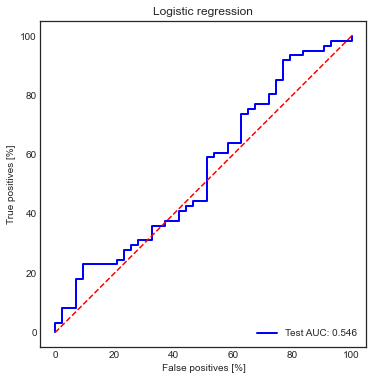

In [117]:
plt.figure(figsize = (6, 6))

plt.title('Logistic regression')
#plot_roc("Train", train_labels, train_predictions_m1, color=colors[2])
plot_roc("Test", weekly_test["Direction2"], X_d_test, color=colors[2]) #, linestyle='--')
plt.legend(loc='lower right')

### (e) Repeat (d) using LDA.

Let's initialize an empty LDA model

In [118]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_d_train, weekly_train["Direction2"])

LinearDiscriminantAnalysis()

In [119]:
print(confusion_matrix(weekly_test['Direction2'], lda.predict(X_d_test)))

[[ 9 34]
 [ 5 56]]


In [120]:
lda.score(X_d_test, weekly_test["Direction2"])

0.625

### (f) Repeat (d) using QDA

In [121]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_d_train, weekly_train['Direction2'])

QuadraticDiscriminantAnalysis()

In [122]:
print(confusion_matrix(weekly_test['Direction2'], qda.predict(X_d_test)))

[[ 0 43]
 [ 0 61]]


In [123]:
qda.score(X_d_test, weekly_test['Direction2'])

0.5865384615384616

### (g) Repeat (d) using KNN with K = 1

In [124]:
# Initiating an empty knn model
knn = neighbors.KNeighborsClassifier(n_neighbors=1)

In [125]:
knn.fit(X_d_train, weekly_train["Direction2"])

KNeighborsClassifier(n_neighbors=1)

In [126]:
print(confusion_matrix(weekly_test['Direction2'], knn.predict(X_d_test)))

[[21 22]
 [30 31]]


In [127]:
knn.score(X_d_test,weekly_test['Direction2'])

0.5

### (h) Repeat (d) using naive Bayes

Why is this dataframe Gaussian? We are able to compute conditional probabilities. P(Y = k | X = x). Gaussain dataframes allow us to work with probabilities. 

In [128]:
#We will assume our dataset follows a Gaussian distribution
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [129]:
gnb.fit(X_d_train, weekly_train['Direction2'])

GaussianNB()

In [130]:
print(confusion_matrix(weekly_test['Direction2'], gnb.predict(X_d_test)))

[[ 0 43]
 [ 0 61]]


In [131]:
gnb.score(X_d_test, weekly_test['Direction2'])

0.5865384615384616

### (i) Which of these methods appears to provide the best results on this data?

<img src = "screen_Shot_2021-10_at_9.57.28_PM.png">

#### The logistic regressison and LDA model provide us with the highest fraction of correct predictions.

### (j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

#### I would like to take 75% or 80% of the "Volume" values in the column for this exercise

In [145]:
%%capture --no-display
weekly_train['Volume_75'] = weekly_train["Volume"]*0.75
weekly_test['Volume_75'] = weekly_test["Volume"] * 0.75

In [146]:
weekly_train.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2,Volume_75
1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0,0.116232
2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0,0.111431
3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1,0.119878
4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1,0.121222
5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1,0.115296


#### The predictors that will be used for this exercise is: Lag3, Lag4, Lag5 and Volume_75

In [139]:
X_j_train = np.array(weekly_train[["Lag3", "Lag4", "Lag5", "Volume_75"]])
X_j_test = np.array(weekly_test[["Lag3", "Lag4", "Lag5", "Volume_75"]])

#### Let's begin again with Logistic regression

In [136]:
lr.fit(X_j_train, weekly_train["Direction2"])

LogisticRegression()

In [142]:
print(confusion_matrix(weekly_test["Direction2"], lr.predict(X_j_test)))
# print(conf_mat)

[[34  9]
 [43 18]]


In [150]:
lr.score((X_j_test), weekly_test["Direction2"])

0.5

In [153]:
# This plot does not work
# plt.figure(figsize = (6, 6))

# plt.title('Logistic regression')
# #plot_roc("Train", train_labels, train_predictions_m1, color=colors[2])
# plot_roc("Test", weekly_test["Direction2"], X_j_test, color=colors[2]) #, linestyle='--')
# plt.legend(loc='lower right')

### LDA

In [154]:
lda.fit(X_j_test, weekly_test["Direction2"])

LinearDiscriminantAnalysis()

In [155]:
print(confusion_matrix(weekly_test['Direction2'], lda.predict(X_j_test)))

[[ 4 39]
 [ 9 52]]


In [156]:
lda.score(X_j_test, weekly_test["Direction2"])

0.5384615384615384

### QDA

In [157]:
qda.fit(X_j_test, weekly_test["Direction2"])

QuadraticDiscriminantAnalysis()

In [158]:
print(confusion_matrix(weekly_test["Direction2"], qda.predict(X_j_test)))

[[21 22]
 [24 37]]


In [159]:
qda.score(X_j_test, weekly_test["Direction2"])

0.5576923076923077

### KNN with neighbors = 2

#### Let us initiate an empty KNN model, but with neighbors = 2

In [166]:
# Initiating an empty knn model
knn2 = neighbors.KNeighborsClassifier(n_neighbors=2)

In [167]:
knn2.fit(X_j_train, weekly_train["Direction2"])
#perhaps use np.array to make it one-dimensional

KNeighborsClassifier(n_neighbors=2)

In [168]:
print(confusion_matrix(weekly_test["Direction2"], knn2.predict(X_j_test)))

[[31 12]
 [52  9]]


In [170]:
print(knn2.score(X_j_test, weekly_test["Direction2"]))

0.38461538461538464


#### It appears that a KNN model with K = 2 fits poorly, the overall prediction score is 0.38

#### Perhaps we initiate a KNN model with K=3

In [171]:
knn3 = neighbors.KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_j_train, weekly_train["Direction2"])
print(confusion_matrix(weekly_test["Direction2"], knn3.predict(X_j_test)))

[[18 25]
 [26 35]]


In [172]:
print(knn3.score(X_j_test, weekly_test["Direction2"]))

0.5096153846153846


#### We see an improvement in the overall prediction score

### Naive Bayes

In [173]:
gnb.fit(X_j_train, weekly_train['Direction2'])

GaussianNB()

In [174]:
print(confusion_matrix(weekly_test["Direction2"], gnb.predict(X_j_test)))

[[42  1]
 [59  2]]


In [179]:
gnb.score(X_j_test, weekly_test["Direction2"])

0.4230769230769231

#### The overall prediction score is not the best, but is higher than our KNN model with K = 2.

### Summary

<img src = "STAT_724_HW2_exercise_j.png">

To see that a QDA model produces the highest fraction of correction predictions is not surprising. I purposely chose my variables to make these models as complex as possible. QDA is appears to be the most flexible of them all.